1](Feature Extraction)

Resize each cropped image to a 224 × 224 pixel image. (Similar to Assignment 1 Question2(a))

In [1]:
import os
from PIL import Image 
import glob
import xml.etree.ElementTree as ET
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

img_dir = r'D:\Data Mining\Programming Assignment - 4\Data Files\Images'
ann_dir = r'D:\Data Mining\Programming Assignment - 4\Data Files\Annotation'

# Function to list items in a directory
def list_directory(dir):
    try:
        items = os.listdir(dir)
        return items
    except FileNotFoundError:
        print(f"Directory '{dir}' not found.")
        return []

dog_images = glob.glob(img_dir+'\\*\\*')
annotations = glob.glob(ann_dir+'\\*\\*')

# Listing of items in both of the directories
isub, asub = list_directory(img_dir), list_directory(ann_dir)
print("Classes in Image Directory:\n",isub)
print("The total Images in four classes are ",len(dog_images))
print("\nClasses in Annotation Directory:\n",asub)
print("The total Annotations in four classes are ",len(annotations))
print()

# From the annotations the range of X and Y coordinates are read
def get_bounding_boxes(ann):
    tree = ET.parse(ann)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

# The function to retrieve image path
def get_image(annot):
    file = annot.split('\\')
    img_filename = img_dir+'\\' + file[-2]+'\\'+file[-1]+'.jpg'
    return img_filename

# Cropping of the Images from all the four classes
for i in range(len(dog_images)):
    bbox = get_bounding_boxes(annotations[i])
    dog = get_image(annotations[i])
    im = Image.open(dog)
    
    # To process the first bounding box
    if bbox:
        im2 = im.crop(bbox[0])
        im2 = im2.resize((224, 224))
        new_path = dog.replace('D:\\Data Mining\\Programming Assignment - 4\\Data Files\\Images\\', '.\\Cropped-1\\')
        new_path = new_path.replace('.jpg','-' + str(0) + '.jpg')
        im2 = im2.convert('RGB')
        head, tail = os.path.split(new_path)
        Path(head).mkdir(parents=True, exist_ok=True)
        im2.save(new_path)
        #print(f"Cropped image saved: {new_path}")  # Confirmation message

    # To process all bounding boxes
    for j in range(len(bbox)):
        im2 = im.crop(bbox[j])
        im2 = im2.resize((224,224))
        new_path = dog.replace('D:\\Data Mining\\Programming Assignment - 4\\Data Files\\Images\\','.\\Cropped-2\\')
        new_path = new_path.replace('.jpg','-' + str(j) + '.jpg')
        im2=im2.convert('RGB')
        head, tail = os.path.split(new_path)
        Path(head).mkdir(parents=True, exist_ok=True)
        im2.save(new_path)
       # print(f"Cropped image saved: {new_path}")  # Confirmation message
print("Images are cropped")

Classes in Image Directory:
 ['n02092002-Scottish_deerhound', 'n02093428-American_Staffordshire_terrier', 'n02094114-Norfolk_terrier', 'n02110958-pug']
The total Images in four classes are  768

Classes in Annotation Directory:
 ['n02092002-Scottish_deerhound', 'n02093428-American_Staffordshire_terrier', 'n02094114-Norfolk_terrier', 'n02110958-pug']
The total Annotations in four classes are  768

Images are cropped


Normalize the resized image dataset.

In [2]:
import os
import torch
from PIL import Image
from torchvision import transforms
from pathlib import Path

# Define the directories
cropped_img_dir = './Cropped-1'
output_dir = './Normalized-Images'

# Ensure the base output directory exists
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Define the normalization transform using ImageNet mean and std
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Define the transform to resize, convert to tensor, and normalize the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing the image
    transforms.ToTensor(),          # Convert image to a PyTorch tensor
    normalize                       # Normalize the image
])

def save_normalized_image(image_path):
    # Open the image file
    with Image.open(image_path) as img:
        # Apply the transform to the image
        img_tensor = transform(img)
        
    # Convert the tensor back to a PIL image
    img_normalized = transforms.ToPILImage()(img_tensor)
    
    # Construct the path for the normalized image
    relative_path = os.path.relpath(image_path, cropped_img_dir)
    new_path = os.path.join(output_dir, relative_path)
    
    # Ensure the directory exists
    os.makedirs(os.path.dirname(new_path), exist_ok=True)
    
    # Save the normalized image
    img_normalized.save(new_path, 'JPEG')

image_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(cropped_img_dir) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg', '.jpeg', '.png']]

# Process each image
for image_file in image_files:
    save_normalized_image(image_file)

print("Normalized images have been saved to their respective class directories.")

Normalized images have been saved to their respective class directories.


Extract features for each image from the last convolution layer of “ResNet18” (You can follow https://kozodoi.me/blog/20210527/extracting-features. But you must reference this website in your solution) (2.5 points)
Reference: https://kozodoi.me/blog/20210527/extracting-features

In [3]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
import os

model = models.resnet18(pretrained=True)
model.eval()

# Modify the model to extract features from the last convolutional layer
class FeatureExtractor(torch.nn.Module):
    def __init__(self, pretrained_model):
        super(FeatureExtractor, self).__init__()
        self.features = torch.nn.Sequential(*list(pretrained_model.children())[:-1])  # Remove the last fully connected layer

    def forward(self, x):
        x = self.features(x)
        return x

# Initialize the feature extractor
feature_extractor = FeatureExtractor(model)

# Image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to load an image and extract features
def extract_and_save_features(image_path, output_dir):
    img = Image.open(image_path).convert('RGB')
    img_t = preprocess(img)
    batch_t = torch.unsqueeze(img_t, 0)
    with torch.no_grad():
        features = feature_extractor(batch_t)
    
    # Construct the output file path
    output_file_path = os.path.join(output_dir, Path(image_path).stem + '.pt')
    os.makedirs(os.path.dirname(output_file_path), exist_ok=True)
    torch.save(features, output_file_path)

image_dir = './Normalized-Images'
output_dir = './Extracted-Features'
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Extract and save features for each image
for img_file in Path(image_dir).rglob('*.jpg'):
    extract_and_save_features(img_file, output_dir)

print("Features extracted and saved for all images.")

Features extracted and saved for all images.


2](Dimension Reduction) Perform dimension reduction on your new dog image representation dataset to reduce the dimension to 2 (similar to Assignment 1 Question 2(f)). (0.5 points)

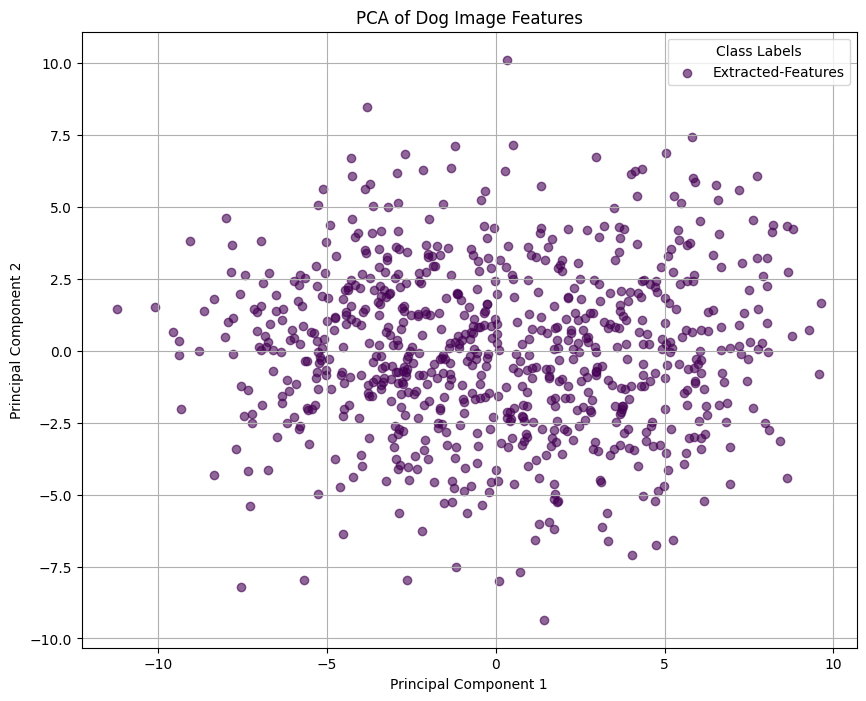

In [4]:
import os
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pathlib import Path

feature_dir = './Extracted-Features'

# Load all feature tensors
def load_features(feature_dir):
    features = []
    file_paths = []
    for feature_file in Path(feature_dir).rglob('*.pt'):
        feature_tensor = torch.load(feature_file)
        features.append(feature_tensor.squeeze().numpy())
        file_paths.append(feature_file)
    return np.array(features), file_paths

# Load features
features, file_paths = load_features(feature_dir)

# Perform PCA dimensionality reduction
pca = PCA(n_components=2)
features_reduced = pca.fit_transform(features)

# Extract class labels from file paths for coloring the plot
class_labels = [Path(file).parts[-2] for file in file_paths]

# Create a color map for the classes
unique_classes = list(set(class_labels))
colors = plt.cm.get_cmap('viridis', len(unique_classes))

colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))
color_map = dict(zip(unique_classes, colors))

plt.figure(figsize=(10, 8))
for class_name in unique_classes:
    class_points = features_reduced[np.array(class_labels) == class_name]
    plt.scatter(class_points[:, 0], class_points[:, 1], label=class_name, 
                color=color_map[class_name], alpha=0.6)

plt.title('PCA of Dog Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class Labels')
plt.grid(True)
plt.show()

3](Clustering Algorithm) Perform clustering using the following approaches on the 2D dataset you preprocessed in Item 2:
• K-mean clustering and its variants for 𝐾 = 4:
(a) K-means clustering: (Use KMeans with init = ‘Random’) (0.5 point)
(b) KMeans with init=‘k-means++’ (0.5 point)
(c) Bisecting K-means (sklearn.cluster.BisectingKMeans with init = ‘Random’) (0.5 point)
(d) spectral clustering (sklearn.cluster.SpectralClustering with default parameters) (0.5 point)
• DBSCAN (0.5 point)
– What are the eps and min samples parameter values you used to get 4 clusters? (0.5 point)
• Agglomerative clustering (i.e., hierarchical clustering) - use sklearn.cluster.AgglomerativeClustering with number of clusters set to 4
(a) Single link (MIN), (0.5 point)
(b) Complete link (MAX), (0.5 point)
(c) Group Average, and (0.5 point)
(d) Ward’s method (0.5 point)
Use the four linkage values ‘ward’, ‘complete’, ‘average’, ‘single’ for sklearn.cluster.AgglomerativeClustering

Estimated eps: 0.9156009378682531 Estimated min_samples: 4


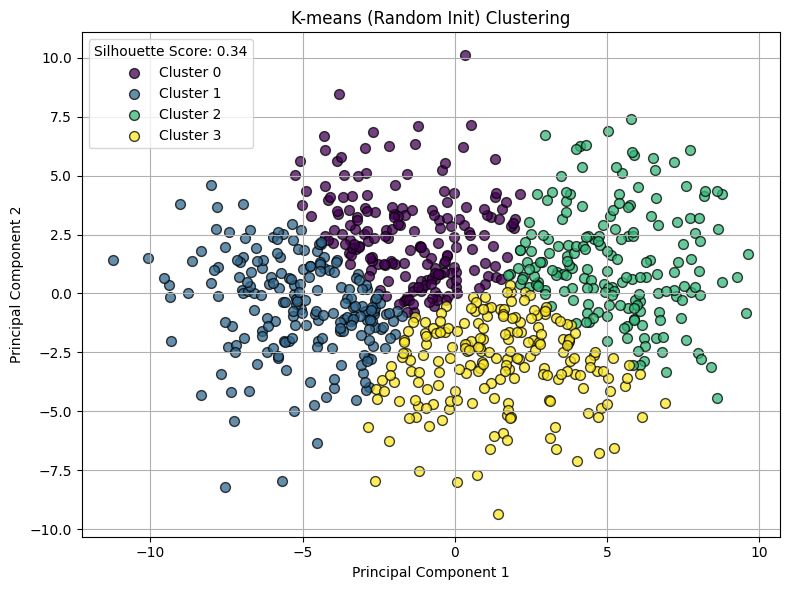

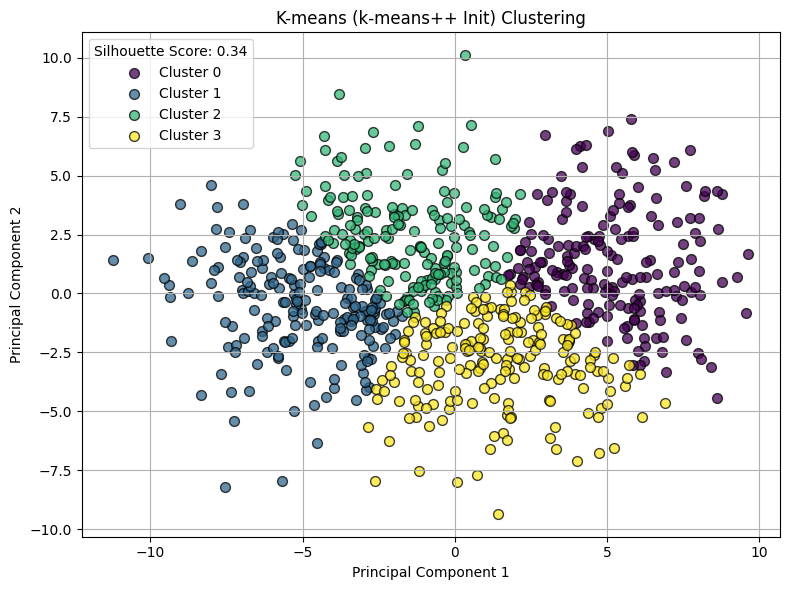

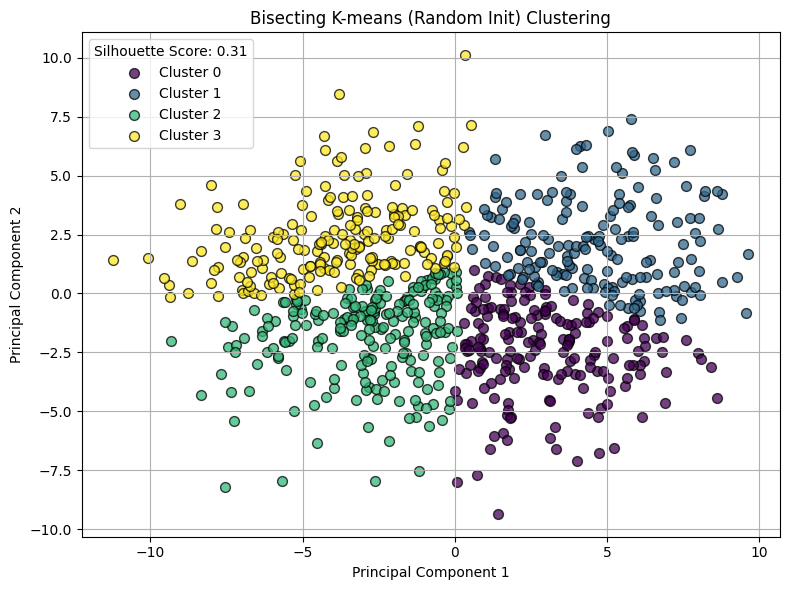

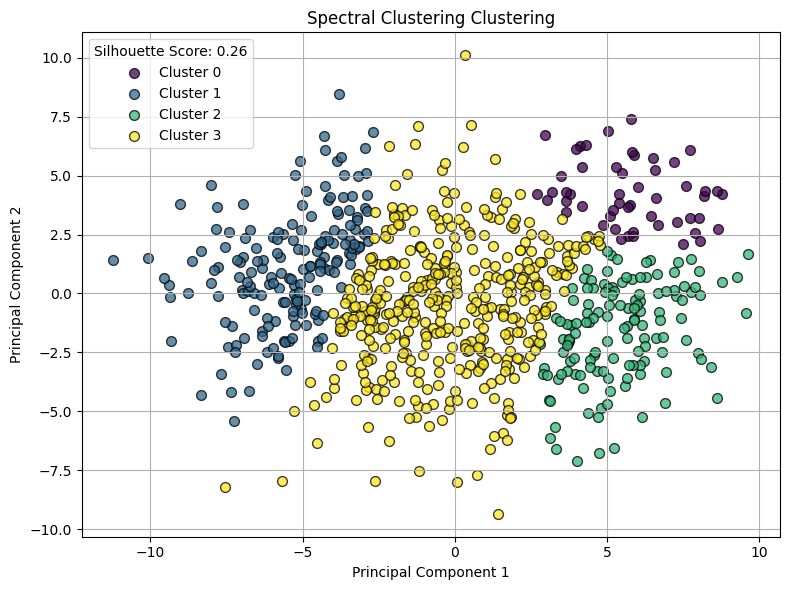

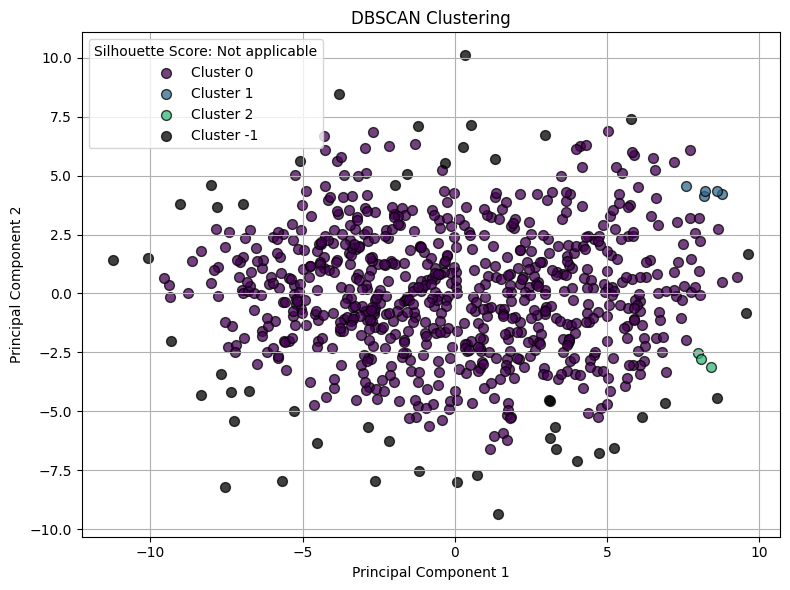

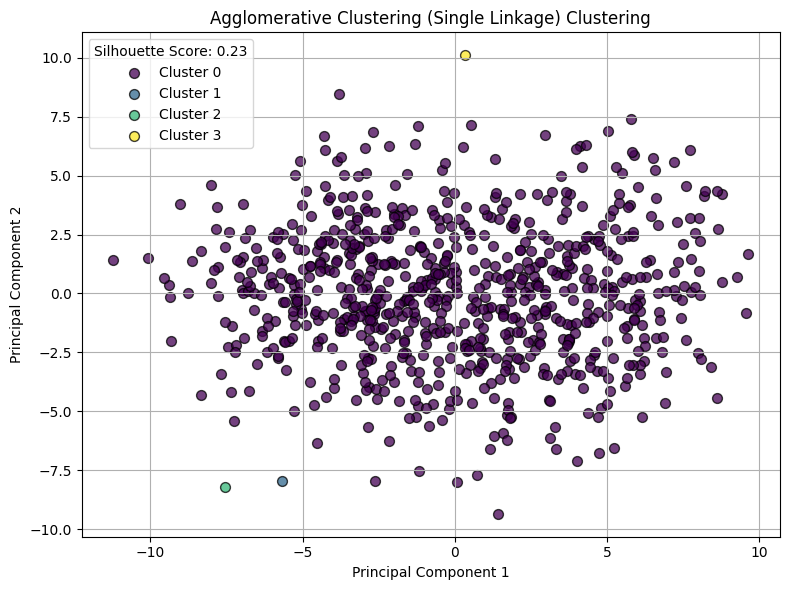

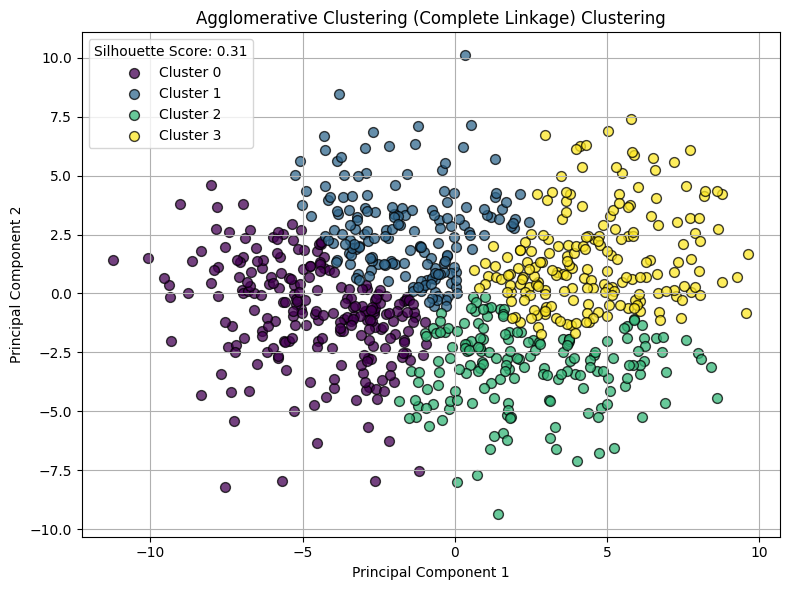

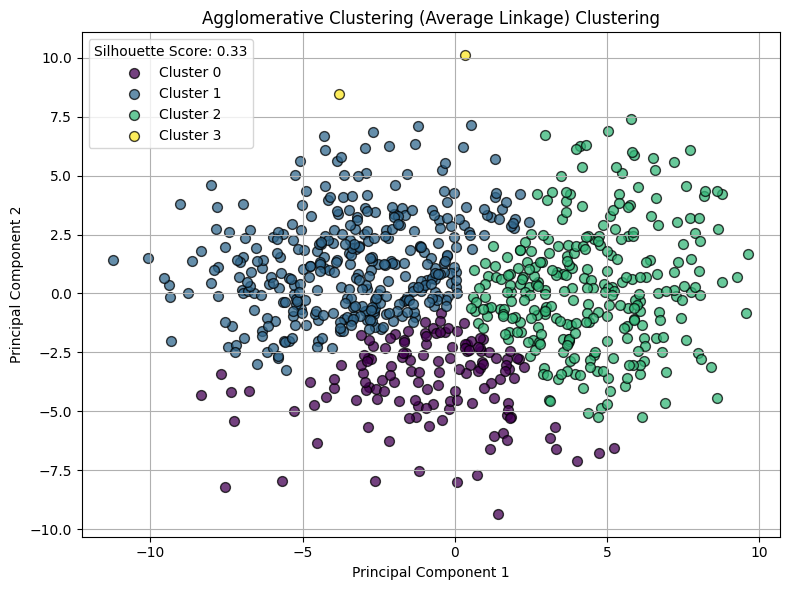

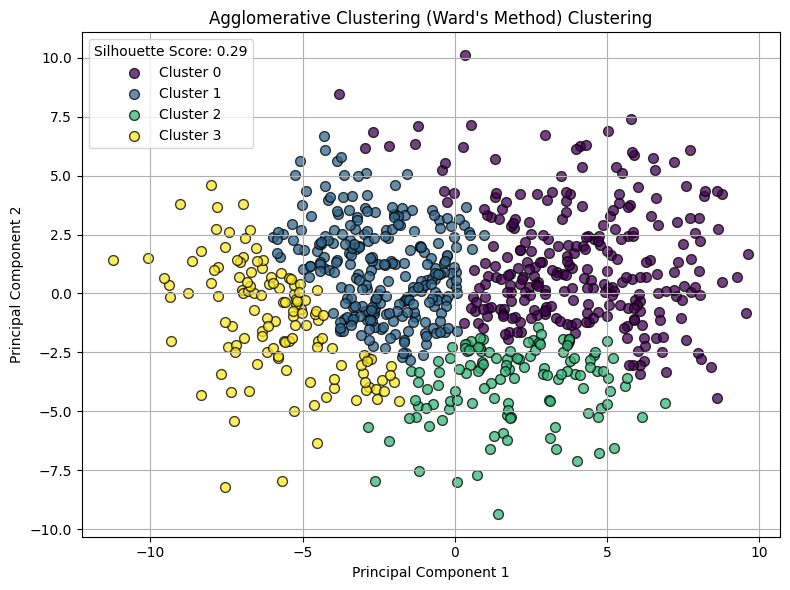

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, BisectingKMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

n_clusters = 4

# DBSCAN Parameter Estimation
def estimate_dbscan_params(data):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)[:, 1]
    
    knee_locator = KneeLocator(range(distances.shape[0]), distances, curve='convex', direction='increasing')
    eps = distances[knee_locator.knee]
    min_samples = 2 * data.shape[1]  # typically twice the dimensionality
    return eps, min_samples

eps, min_samples = estimate_dbscan_params(features_reduced)
print("Estimated eps:", eps, "Estimated min_samples:", min_samples)

# Define and instantiate clustering models
models = {
    'K-means (Random Init)': KMeans(n_clusters=n_clusters, init='random', random_state=42),
    'K-means (k-means++ Init)': KMeans(n_clusters=n_clusters, init='k-means++', random_state=42),
    'Bisecting K-means (Random Init)': BisectingKMeans(n_clusters=n_clusters, init='random', random_state=42),
    'Spectral Clustering': SpectralClustering(n_clusters=n_clusters, random_state=42),
    'DBSCAN': DBSCAN(eps=eps, min_samples=min_samples),  # Use estimated parameters
    'Agglomerative Clustering (Single Linkage)': AgglomerativeClustering(n_clusters=n_clusters, linkage='single'),
    'Agglomerative Clustering (Complete Linkage)': AgglomerativeClustering(n_clusters=n_clusters, linkage='complete'),
    'Agglomerative Clustering (Average Linkage)': AgglomerativeClustering(n_clusters=n_clusters, linkage='average'),
    'Agglomerative Clustering (Ward\'s Method)': AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
}

def plot_clusters(model, model_name, data):
    labels = model.fit_predict(data)
    unique_labels = set(labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

    plt.figure(figsize=(8, 6))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'k'  # Black used for noise.
        class_member_mask = (labels == k)
        xy = data[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], color=col, edgecolor='k', s=50, alpha=0.75, label=f'Cluster {k}')
    
    plt.title(f'{model_name} Clustering')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    if -1 not in unique_labels and len(unique_labels) > 1:
        score = silhouette_score(data, labels)
        plt.legend(title=f'Silhouette Score: {score:.2f}')
    else:
        plt.legend(title='Silhouette Score: Not applicable')
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()    

# Apply and plot each clustering
for name, model in models.items():
    plot_clusters(model, name, features_reduced)

4](Clustering Evaluations) For all the methods in Item 3:
(a) Perform clustering performance evaluation using Fowlkes-Mallows index (sklearn.metrics.fowlkes mallows score). Compute the Fowlkes-Mallows index for each method on the 2D dataset. (0.5 point)
(b) Perform clustering performance evaluation using Silhouette Coefficient (sklearn.metrics.silhouette score). Compute the Silhouette Coefficient for each method. (0.5 point)
(c) Rank the methods from the best to the worst for your dataset based on Fowlkes-Mallows index.(0.5 point)
(d) Rank the methods from the best to the worst for your dataset based on Silhouette Coefficient.(0.5 point)

In [6]:
import os

image_directory = r'D:\Data Mining\Programming Assignment - 4\Data Files\Images'

true_labels = []

for class_folder in os.listdir(image_directory):
    class_folder_path = os.path.join(image_directory, class_folder)
    
    if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
            true_labels.append(class_folder.split('-')[1])

# Output the total number of labels collected
print("Total labels collected:", len(true_labels))

Total labels collected: 768


In [7]:
import numpy as np
from sklearn.metrics import fowlkes_mallows_score, silhouette_score
from sklearn.cluster import KMeans, BisectingKMeans, SpectralClustering, DBSCAN, AgglomerativeClustering

models = {
    'K-means (Random Init)': KMeans(n_clusters=4, init='random', random_state=42),
    'K-means (k-means++ Init)': KMeans(n_clusters=4, init='k-means++', random_state=42),
    'Bisecting K-means (Random Init)': BisectingKMeans(n_clusters=4, init='random', random_state=42),
    'Spectral Clustering': SpectralClustering(n_clusters=4, random_state=42),
    'DBSCAN': DBSCAN(eps=eps, min_samples=min_samples),  # Adjust 'eps' and 'min_samples' as previously calculated
    'Agglomerative Clustering (Single Linkage)': AgglomerativeClustering(n_clusters=4, linkage='single'),
    'Agglomerative Clustering (Complete Linkage)': AgglomerativeClustering(n_clusters=4, linkage='complete'),
    'Agglomerative Clustering (Average Linkage)': AgglomerativeClustering(n_clusters=4, linkage='average'),
    'Agglomerative Clustering (Ward\'s Method)': AgglomerativeClustering(n_clusters=4, linkage='ward')
}

# Dictionary to store evaluation metrics
evaluation_metrics = {}

for name, model in models.items():
    # Fit the model and predict the clusters
    predicted_labels = model.fit_predict(features_reduced)
    
    # Compute Fowlkes-Mallows index
    if len(np.unique(predicted_labels)) > 1:  # Check necessary because FMI cannot be calculated for one cluster
        fmi = fowlkes_mallows_score(true_labels, predicted_labels)
        print(f"Fowlkes-Mallows Index for {name}: {fmi:.3f}")
    else:
        fmi = None  # or some indicative value
        print(f"Fowlkes-Mallows Index for {name}: Not applicable")
    
    # Compute Silhouette Coefficient
    if len(np.unique(predicted_labels)) > 1 and len(np.unique(predicted_labels)) < len(predicted_labels):  # Silhouette score requires more than one cluster and less than n samples
        silhouette = silhouette_score(features_reduced, predicted_labels)
        print(f"Silhouette Coefficient for {name}: {silhouette:.3f}")
    else:
        silhouette = None  # or some indicative value
        print(f"Silhouette Coefficient for {name}: Not applicable")
    
    evaluation_metrics[name] = (fmi, silhouette)

# Sort and rank based on Fowlkes-Mallows index
fmi_ranking = sorted(evaluation_metrics.items(), key=lambda x: x[1][0] if x[1][0] is not None else -1, reverse=True)

# Sort and rank based on Silhouette Coefficient
silhouette_ranking = sorted(evaluation_metrics.items(), key=lambda x: x[1][1] if x[1][1] is not None else -1, reverse=True)

# Print rankings
print("\nRanking based on Fowlkes-Mallows Index:")
for rank, (name, scores) in enumerate(fmi_ranking, start=1):
    print(f"{rank}. {name} - FMI: {scores[0]}")

print("\nRanking based on Silhouette Coefficient:")
for rank, (name, scores) in enumerate(silhouette_ranking, start=1):
    print(f"{rank}. {name} - Silhouette: {scores[1]}")

Fowlkes-Mallows Index for K-means (Random Init): 0.310
Silhouette Coefficient for K-means (Random Init): 0.336
Fowlkes-Mallows Index for K-means (k-means++ Init): 0.310
Silhouette Coefficient for K-means (k-means++ Init): 0.336
Fowlkes-Mallows Index for Bisecting K-means (Random Init): 0.312
Silhouette Coefficient for Bisecting K-means (Random Init): 0.310
Fowlkes-Mallows Index for Spectral Clustering: 0.344
Silhouette Coefficient for Spectral Clustering: 0.262
Fowlkes-Mallows Index for DBSCAN: 0.466
Silhouette Coefficient for DBSCAN: 0.087
Fowlkes-Mallows Index for Agglomerative Clustering (Single Linkage): 0.502
Silhouette Coefficient for Agglomerative Clustering (Single Linkage): 0.228
Fowlkes-Mallows Index for Agglomerative Clustering (Complete Linkage): 0.313
Silhouette Coefficient for Agglomerative Clustering (Complete Linkage): 0.308
Fowlkes-Mallows Index for Agglomerative Clustering (Average Linkage): 0.375
Silhouette Coefficient for Agglomerative Clustering (Average Linkage): 